# [Wuyeh Jobe](http://wuyeh-jobe.gamfruits.com/)

#### This solution was built on the starter notebook shared by Zindi.
For the winning solution, the main things that improved the model were using catboost instead of logistic regression, removing some features with either less training data or long texts, and experimeting with the learning rate and training epochs. There was no time to try our GridSearch for selecting optimal parameters.

# UmojaHack Rwanda: Expresso Churn Prediction Challenge

When customers leave, this can be very costly for the company, thus firms are interested in predicting churn beforehand. Having that information in hand can help companies change their strategy to retain customers.

In this starter notebook, we'll walk through the competition. We will show you how to load the data and do a quick exploratory analysis. Then, we will train a simple model, make some predictions, and then submit those predictions to the competition.

The data we have describes 2.5 million [Expresso](https://www.expressotelecom.sn/) clients. Expresso is an African telecommunications services company that provides telecommunication services in five African markets: Mauritania, Senegal, Guinea, and Ghana. Expresso offers a wide range of products and services to meet the needs of customers.

The objective of this hackathon is to develop a predictive model that determines the likelihood for a customer to churn - to stop purchasing airtime and data from Expresso. Let's dig in!

## Table of Contents:
&nbsp;&nbsp;1. [LOADING THE DATA](#1)
   
&nbsp;&nbsp;2. [EXPLORING THE DATA](#2)   

&nbsp;&nbsp;3. [BUILDING SOME MODELS](#3)   

&nbsp;&nbsp;4. [GENERATING THE PREDICTIONS FOR THE TEST SET](#4)

# LOADING THE DATA

On the [data description page](https://zindi.africa/hackathons/umojahack-rwanda-expresso-churn-prediction-challenge/data), we are provided with everything we need to get started:

Train.csv: this is what you will use to train your model.

Test.csv: this is what you will test your model on.

SampleSubmission.csv: This file serves as an example for how to format your submission.

Let's start by importing the libraries that we will need to load and explore the data.

In [1]:
# !pip install missingno

In [2]:
##importing packages
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np


Next, we can load the datasets and begin taking a look.

In [3]:
#reading in the data
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


Each row is/was an expresso client. The columns are the different attributes of the customers. 

In [5]:
train.info()#quite the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
user_id           object
REGION            object
TENURE            object
MONTANT           float64
FREQUENCE_RECH    float64
REVENUE           float64
ARPU_SEGMENT      float64
FREQUENCE         float64
DATA_VOLUME       float64
ON_NET            float64
ORANGE            float64
TIGO              float64
ZONE1             float64
ZONE2             float64
MRG               object
REGULARITY        int64
TOP_PACK          object
FREQ_TOP_PACK     float64
CHURN             int64
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


There are more than 2M customers in the training set.

In [6]:
test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,THIES,K > 24 month,5000.0,5.0,5000.0,1667.0,5.0,NaN,378.0,11.0,5.0,NaN,NaN,NO,42,On-net 1000F=10MilF;10d,5.0
1,000055d41c8a62052dd426592e8a4a3342bf565d,NaN,I 18-21 month,300.0,2.0,326.0,109.0,3.0,397.0,NaN,0.0,NaN,NaN,NaN,NO,41,"Data: 100 F=40MB,24H",1.0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,DAKAR,K > 24 month,3300.0,25.0,3400.0,1133.0,26.0,7150.0,0.0,2.0,5.0,NaN,NaN,NO,57,"Data: 100 F=40MB,24H",22.0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,9,NaN,NaN
4,0000bae5480628cf8fe51ad84bcb39772fc79224,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,10,NaN,NaN


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380127 entries, 0 to 380126
Data columns (total 18 columns):
user_id           380127 non-null object
REGION            230399 non-null object
TENURE            380127 non-null object
MONTANT           247072 non-null float64
FREQUENCE_RECH    247072 non-null float64
REVENUE           252754 non-null float64
ARPU_SEGMENT      252754 non-null float64
FREQUENCE         252754 non-null float64
DATA_VOLUME       193087 non-null float64
ON_NET            241613 non-null float64
ORANGE            222897 non-null float64
TIGO              153126 non-null float64
ZONE1             29861 non-null float64
ZONE2             24076 non-null float64
MRG               380127 non-null object
REGULARITY        380127 non-null int64
TOP_PACK          221348 non-null object
FREQ_TOP_PACK     221348 non-null float64
dtypes: float64(12), int64(1), object(5)
memory usage: 52.2+ MB


In [8]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0]

,Total,Percent
ZONE2,2017224,0.936481
ZONE1,1984327,0.921208
TIGO,1290016,0.598880
DATA_VOLUME,1060433,0.492298
TOP_PACK,902594,0.419022
FREQ_TOP_PACK,902594,0.419022
ORANGE,895248,0.415612
REGION,849299,0.394280
ON_NET,786675,0.365208
MONTANT,756739,0.351310


In [9]:
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0]

,Total,Percent
ZONE2,356051,0.936663
ZONE1,350266,0.921445
TIGO,227001,0.597171
DATA_VOLUME,187040,0.492046
TOP_PACK,158779,0.417700
FREQ_TOP_PACK,158779,0.417700
ORANGE,157230,0.413625
REGION,149728,0.393889
ON_NET,138514,0.364389
FREQUENCE_RECH,133055,0.350028


In [10]:
train.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,1.397309e+06,1.397309e+06,1.428000e+06,1.428000e+06,1.428000e+06,1.093615e+06,1.367373e+06,1.258800e+06,864032.000000,169721.000000,136824.000000,2.154048e+06,1.251454e+06,2.154048e+06
mean,5.532117e+03,1.152912e+01,5.510810e+03,1.836943e+03,1.397814e+01,3.366450e+03,2.776891e+02,9.541871e+01,23.109253,8.170132,7.553309,2.804251e+01,9.272461e+00,1.875474e-01
std,7.111339e+03,1.327407e+01,7.187113e+03,2.395700e+03,1.469403e+01,1.330446e+04,8.726889e+02,2.049873e+02,63.578086,41.169511,33.487234,2.228686e+01,1.228044e+01,3.903504e-01
min,1.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+03,2.000000e+00,1.000000e+03,3.330000e+02,3.000000e+00,0.000000e+00,5.000000e+00,7.000000e+00,2.000000,0.000000,0.000000,6.000000e+00,2.000000e+00,0.000000e+00
50%,3.000000e+03,7.000000e+00,3.000000e+03,1.000000e+03,9.000000e+00,2.570000e+02,2.700000e+01,2.900000e+01,6.000000,1.000000,2.000000,2.400000e+01,5.000000e+00,0.000000e+00
75%,7.350000e+03,1.600000e+01,7.368000e+03,2.456000e+03,2.000000e+01,2.895000e+03,1.560000e+02,9.900000e+01,20.000000,3.000000,5.000000,5.100000e+01,1.200000e+01,0.000000e+00
max,4.700000e+05,1.330000e+02,5.321770e+05,1.773920e+05,9.100000e+01,1.823866e+06,5.080900e+04,2.132300e+04,4174.000000,4792.000000,3697.000000,6.200000e+01,7.130000e+02,1.000000e+00


In [11]:
test.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
count,247072.000000,247072.000000,252754.000000,252754.000000,252754.000000,193087.000000,241613.000000,222897.000000,153126.000000,29861.000000,24076.000000,380127.000000,221348.000000
mean,5524.958826,11.519853,5499.680468,1833.232443,13.957963,3346.095454,278.806310,95.193008,23.052088,8.164663,7.655300,28.081699,9.261584
std,7116.320922,13.242743,7195.093138,2398.360570,14.652660,12002.653047,874.253933,203.950776,65.042688,48.857605,33.021478,22.289094,12.268907
min,25.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000,2.000000
50%,3000.000000,7.000000,3000.000000,1000.000000,9.000000,259.000000,27.000000,29.000000,6.000000,1.000000,2.000000,24.000000,5.000000
75%,7350.000000,16.000000,7351.000000,2450.000000,19.000000,2884.000000,157.000000,99.000000,20.000000,3.000000,5.000000,51.000000,12.000000
max,201500.000000,146.000000,200965.000000,66988.000000,91.000000,977796.000000,26786.000000,6345.000000,3708.000000,4215.000000,1649.000000,62.000000,390.000000


In [12]:
train.describe(exclude = np.number)#no duplicates in user_id, MRG is useless

,user_id,REGION,TENURE,MRG,TOP_PACK
count,2154048,1304749,2154048,2154048,1251454
unique,2154048,14,8,1,140
top,e2c8b817d16081336dcb560848fa9d04238801fd,DAKAR,K > 24 month,NO,All-net 500F=2000F;5d
freq,1,513271,2043201,2154048,317802


In [13]:
test.describe(exclude = np.number)

,user_id,REGION,TENURE,MRG,TOP_PACK
count,380127,230399,380127,380127,221348
unique,380127,14,8,1,102
top,49e52a1afbf4db74907ed0ee08c9665bd63ac9d7,DAKAR,K > 24 month,NO,All-net 500F=2000F;5d
freq,1,90615,360350,380127,56038


Let's delete the 'MRG' column since it consists of a single value. Also, let's delete colums 'ZONE2' and 'ZONE1' since they have so many missing values. 

In [14]:
train = train.drop(['MRG', 'ZONE2', 'ZONE1'], axis = 1)
test = test.drop(['MRG', 'ZONE2', 'ZONE1'], axis = 1)

In [15]:
train.REGION.unique()

array(['FATICK', nan, 'DAKAR', 'LOUGA', 'TAMBACOUNDA', 'KAOLACK', 'THIES',
       'SAINT-LOUIS', 'KOLDA', 'KAFFRINE', 'DIOURBEL', 'ZIGUINCHOR',
       'MATAM', 'SEDHIOU', 'KEDOUGOU'], dtype=object)

In [16]:
train.TENURE.unique()

array(['K > 24 month', 'I 18-21 month', 'G 12-15 month', 'H 15-18 month',
       'J 21-24 month', 'F 9-12 month', 'D 3-6 month', 'E 6-9 month'],
      dtype=object)

In [17]:
print(train.shape)
print()
print(test.shape)

(2154048, 16)

(380127, 15)


In [18]:
# train = train.fillna(train.mean())


# EXPLORING THE DATA

Let's start by looking at the distribution of our target variable.

CHURN
0    1750062
1     403986
dtype: int64


Text(0, 0.5, 'Frequency')

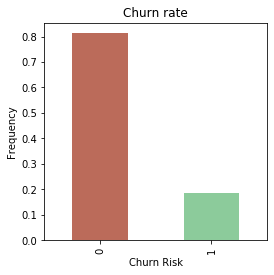

In [19]:
print(train.groupby(['CHURN']).size())
#bar chart to show distribution of the target variable
n_obs = train.shape[0]
#index = ['No','Yes']
churn_plot = train['CHURN'].value_counts().div(n_obs).plot(kind='bar',figsize=(4,4),title="Churn rate", color=['#BB6B5A','#8CCB9B'])
churn_plot.set_xlabel("Churn Risk")
churn_plot.set_ylabel("Frequency")

It is imbalanced, with more than 80% of customers staying. Next, let's take a look at our features. We have a mix of continous and categorical features. 

Let's begin with the categorical features and investigate how the churn rate differ across the various levels of each categorical feature.

In [20]:
def attrition_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of churn rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (train[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax, color = ['g', 'r'])
    ax.invert_yaxis()
    ax.legend().remove()

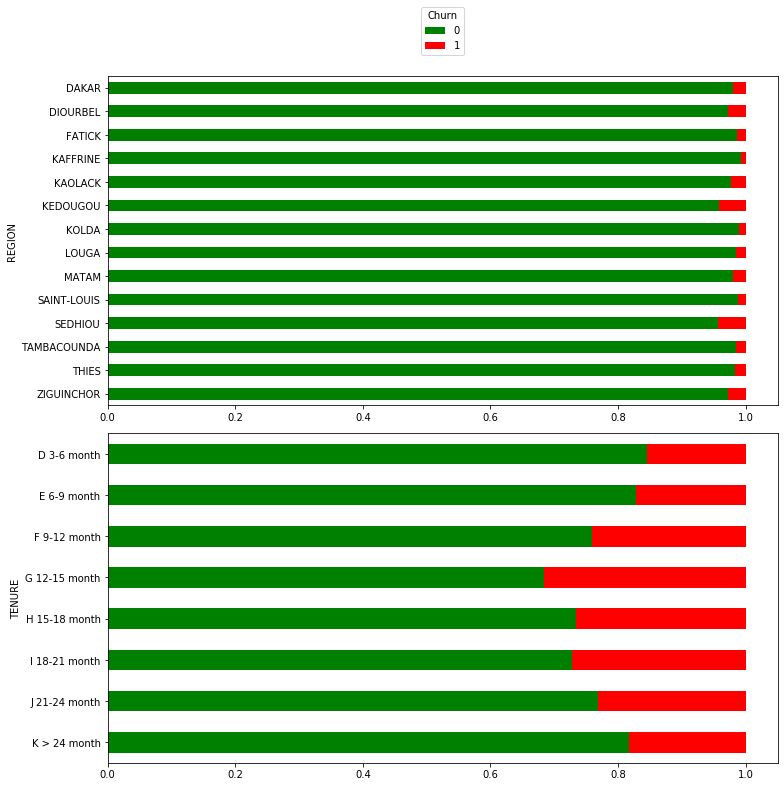

In [21]:
cols_to_plot = [
    'REGION',
    'TENURE'
]

fig, ax = plt.subplots(
    len(cols_to_plot), 1, figsize=(11,11)
)
for idx, col in enumerate(cols_to_plot):
    attrition_rate_plot(
        col, 'CHURN', train, ax=ax[idx]
    )

ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Churn'
)

fig.tight_layout()

It looks like customers with tenure between 12 and 15 months have the highest churn rate while new customers have the lowest.

Now, let's look at the relationship between the recharge amount and the monthly revenue

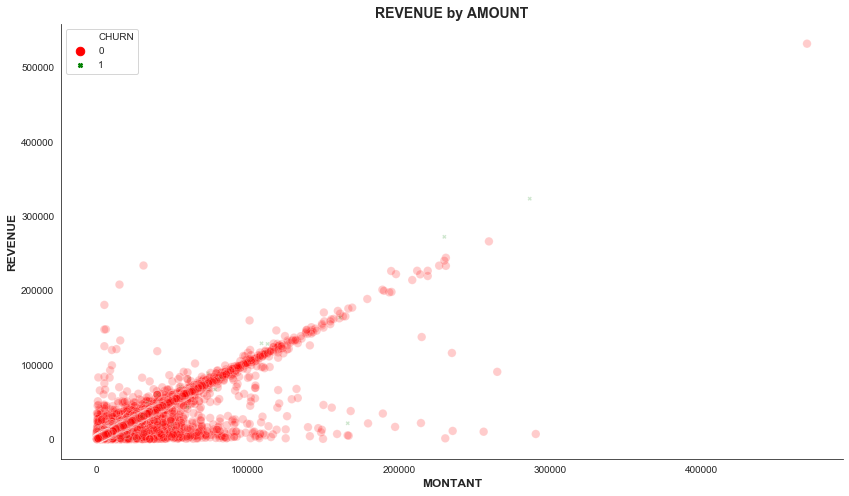

In [22]:
# Set initial plot options
sns.set_style('white')
plt.figure(figsize = (14, 8))

# Create scatterplot
sns.scatterplot(x = "MONTANT", 
                y = "REVENUE", 
                # Group by and change dot style and  by CHURN
                hue = "CHURN",
                size = "CHURN",  
                style = "CHURN", 
                data = train, 
                # Change color of hue categories
                palette = ["r", "g"],
                alpha = 0.2)

# Despine plot
sns.despine()
# Final formatting touches
plt.xlabel("MONTANT", fontsize = 12, fontweight = "semibold")
plt.ylabel("REVENUE", fontsize = 12, fontweight = "semibold")
plt.title("REVENUE by AMOUNT", fontsize = 14, fontweight = "semibold")
plt.show()

There seems to be some correlation between the two and also there's some outliers. Outliers can create bias in a model's performance. Should we keep them or remove them? I will let you decide.

# BUILDING SOME MODELS

Let's train a model using the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). We chose the logistic regression because it is fast and serve as a good baseline.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import AdaBoostClassifier

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import log_loss

RANDOM_SEED = 123    # Set a random seed for reproducibility!

Some models, including logistic regression, only work with numeric input for features. So we'll either have to drop the categorical features or transform them. We'll opt for the later since we want to capture as much as information as we can. To do this, we'll use a method called [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

We also need to do some preprocessing for the numeric features. We have to scale each numeric feature and the reason for that is because we are using [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). We will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), it transforms each feature such that its distribution has a mean value of 0 and a standard deviation of 1.

Another issue we have to take care of is the missing values since logistic regression can't handle them. For that, we'll use theSimpleImputer (https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) function.

This is quite a lot of steps but not to worry, we'll use Scikit-Learn's built-in composition functionality to encapsulate everything into a pipeline. 

### Feature Preprocessing

In [25]:
train.columns[train.dtypes != "object"].values

array(['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT',
       'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'REGULARITY', 'FREQ_TOP_PACK', 'CHURN'], dtype=object)

In [26]:
numeric_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT',
       'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'REGULARITY', 'FREQ_TOP_PACK']

print(numeric_cols)

['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY', 'FREQ_TOP_PACK']


In [27]:
## The top_pack feature is removed from features

In [28]:
categorical_cols = ['REGION', 'TENURE']

['REGION', 'TENURE']


In [29]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator = True))
])

categorical_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='Missing', add_indicator = True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ('categorical', categorical_preprocessing_steps, categorical_cols)
    ],
    remainder = "drop"
)

### Putting Together the Full Pipeline

We put both the preprocessing functions and the estimatior into one Pipeline object, this allows to run the data through all the steps in one interface.

##### The catboost classifier was used with an iteration of 500, learning rate of 0.2, and logloss loss function
##### This was determined based on trial and errror and observation
##### Gridsearch could have been used if I had more time

In [30]:
!pip install catboost

You should consider upgrading via the 'c:\users\jwuye\anaconda3\python.exe -m pip install --upgrade pip' command.


In [31]:
from catboost import CatBoostClassifier

full_pipeline4 = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", CatBoostClassifier(iterations=500, 
                           loss_function='Logloss', 
                                     learning_rate=0.2,
                           verbose=True, random_state=123) 
),
])

### Training and Evaluation

Let's split the data into a training and evaluation set. We'll use a third of our data for evaluation. 

Recall that we have an imbalanced dataset, so we'll use the stratify argument to enforce even splits.

###### Aside from user_id and Churn, Top_pack is removed from the training dataframe

In [32]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train.drop(['user_id', 'CHURN','TOP_PACK'], axis = 1),
    train.CHURN,
    test_size=0.33,
    shuffle=True,
    stratify=train.CHURN,
    random_state=RANDOM_SEED
)

### The pipeline with catboost is used for training

In [33]:
full_pipeline4.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline4.predict_proba(X_eval)
print("score for {}".format('Catbooste'))
print(log_loss(y_eval, preds[:, 1]))

0:	learn: 0.4404215	total: 1.1s	remaining: 9m 7s
1:	learn: 0.3409531	total: 1.53s	remaining: 6m 20s
2:	learn: 0.2991979	total: 1.96s	remaining: 5m 25s
3:	learn: 0.2793989	total: 2.27s	remaining: 4m 40s
4:	learn: 0.2686998	total: 2.53s	remaining: 4m 10s
5:	learn: 0.2632147	total: 2.81s	remaining: 3m 51s
6:	learn: 0.2595202	total: 3.14s	remaining: 3m 40s
7:	learn: 0.2575818	total: 3.44s	remaining: 3m 31s
8:	learn: 0.2563232	total: 3.73s	remaining: 3m 23s
9:	learn: 0.2552917	total: 4s	remaining: 3m 16s
10:	learn: 0.2547515	total: 4.28s	remaining: 3m 10s
11:	learn: 0.2542527	total: 4.71s	remaining: 3m 11s
12:	learn: 0.2540056	total: 5.08s	remaining: 3m 10s
13:	learn: 0.2536639	total: 5.33s	remaining: 3m 5s
14:	learn: 0.2535293	total: 5.59s	remaining: 3m
15:	learn: 0.2534037	total: 5.89s	remaining: 2m 58s
16:	learn: 0.2532975	total: 6.18s	remaining: 2m 55s
17:	learn: 0.2531346	total: 6.5s	remaining: 2m 53s
18:	learn: 0.2530146	total: 6.81s	remaining: 2m 52s
19:	learn: 0.2529427	total: 7.09s

158:	learn: 0.2504042	total: 53.8s	remaining: 1m 55s
159:	learn: 0.2503968	total: 54.2s	remaining: 1m 55s
160:	learn: 0.2503961	total: 54.4s	remaining: 1m 54s
161:	learn: 0.2503823	total: 54.7s	remaining: 1m 54s
162:	learn: 0.2503686	total: 55.1s	remaining: 1m 53s
163:	learn: 0.2503572	total: 55.4s	remaining: 1m 53s
164:	learn: 0.2503486	total: 55.7s	remaining: 1m 53s
165:	learn: 0.2503428	total: 56.1s	remaining: 1m 52s
166:	learn: 0.2503370	total: 56.4s	remaining: 1m 52s
167:	learn: 0.2503297	total: 56.7s	remaining: 1m 52s
168:	learn: 0.2503238	total: 57s	remaining: 1m 51s
169:	learn: 0.2503236	total: 57.3s	remaining: 1m 51s
170:	learn: 0.2503188	total: 57.6s	remaining: 1m 50s
171:	learn: 0.2503122	total: 57.9s	remaining: 1m 50s
172:	learn: 0.2503087	total: 58.2s	remaining: 1m 50s
173:	learn: 0.2503002	total: 58.5s	remaining: 1m 49s
174:	learn: 0.2502914	total: 58.9s	remaining: 1m 49s
175:	learn: 0.2502784	total: 59.2s	remaining: 1m 49s
176:	learn: 0.2502751	total: 59.6s	remaining: 1m

312:	learn: 0.2493770	total: 1m 43s	remaining: 1m 1s
313:	learn: 0.2493702	total: 1m 43s	remaining: 1m 1s
314:	learn: 0.2493644	total: 1m 44s	remaining: 1m 1s
315:	learn: 0.2493580	total: 1m 44s	remaining: 1m
316:	learn: 0.2493497	total: 1m 44s	remaining: 1m
317:	learn: 0.2493461	total: 1m 45s	remaining: 1m
318:	learn: 0.2493435	total: 1m 45s	remaining: 59.8s
319:	learn: 0.2493382	total: 1m 45s	remaining: 59.5s
320:	learn: 0.2493321	total: 1m 46s	remaining: 59.2s
321:	learn: 0.2493287	total: 1m 46s	remaining: 58.8s
322:	learn: 0.2493187	total: 1m 46s	remaining: 58.5s
323:	learn: 0.2493128	total: 1m 47s	remaining: 58.2s
324:	learn: 0.2493069	total: 1m 47s	remaining: 57.8s
325:	learn: 0.2492981	total: 1m 47s	remaining: 57.5s
326:	learn: 0.2492881	total: 1m 48s	remaining: 57.1s
327:	learn: 0.2492834	total: 1m 48s	remaining: 56.8s
328:	learn: 0.2492818	total: 1m 48s	remaining: 56.5s
329:	learn: 0.2492748	total: 1m 49s	remaining: 56.2s
330:	learn: 0.2492720	total: 1m 49s	remaining: 55.9s
33

469:	learn: 0.2484907	total: 2m 37s	remaining: 10.1s
470:	learn: 0.2484838	total: 2m 38s	remaining: 9.74s
471:	learn: 0.2484802	total: 2m 38s	remaining: 9.41s
472:	learn: 0.2484755	total: 2m 38s	remaining: 9.07s
473:	learn: 0.2484691	total: 2m 39s	remaining: 8.74s
474:	learn: 0.2484654	total: 2m 39s	remaining: 8.41s
475:	learn: 0.2484586	total: 2m 40s	remaining: 8.07s
476:	learn: 0.2484524	total: 2m 40s	remaining: 7.74s
477:	learn: 0.2484445	total: 2m 40s	remaining: 7.4s
478:	learn: 0.2484385	total: 2m 41s	remaining: 7.07s
479:	learn: 0.2484353	total: 2m 41s	remaining: 6.74s
480:	learn: 0.2484289	total: 2m 42s	remaining: 6.4s
481:	learn: 0.2484213	total: 2m 42s	remaining: 6.07s
482:	learn: 0.2484191	total: 2m 43s	remaining: 5.74s
483:	learn: 0.2484137	total: 2m 43s	remaining: 5.41s
484:	learn: 0.2484074	total: 2m 43s	remaining: 5.07s
485:	learn: 0.2484020	total: 2m 44s	remaining: 4.73s
486:	learn: 0.2483960	total: 2m 44s	remaining: 4.4s
487:	learn: 0.2483879	total: 2m 45s	remaining: 4.

The competition uses the [Log loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) as the evaluation metric, so let's check how our model did on the evaluation set.

The estimator spits out the probabilities for each class(0 and 1). We are interested in the second column, that is the probability of churn,so let's grab it.

### Retrain Model on Full Dataset

Now that we have an idea of how the model performs, let's retrain on the full training set

In [34]:
%%time 

full_pipeline4.fit(train.drop(['user_id', 'CHURN', 'TOP_PACK'], axis = 1), train.CHURN)

None   # So we don't print out the whole pipeline representation

0:	learn: 0.4316751	total: 1.24s	remaining: 10m 18s
1:	learn: 0.3375085	total: 1.83s	remaining: 7m 36s
2:	learn: 0.2973976	total: 2.43s	remaining: 6m 43s
3:	learn: 0.2785993	total: 3.05s	remaining: 6m 17s
4:	learn: 0.2685890	total: 3.7s	remaining: 6m 6s
5:	learn: 0.2627971	total: 4.38s	remaining: 6m
6:	learn: 0.2598014	total: 4.9s	remaining: 5m 45s
7:	learn: 0.2574966	total: 5.4s	remaining: 5m 32s
8:	learn: 0.2563664	total: 5.94s	remaining: 5m 24s
9:	learn: 0.2553207	total: 6.52s	remaining: 5m 19s
10:	learn: 0.2546910	total: 7.07s	remaining: 5m 14s
11:	learn: 0.2542992	total: 7.58s	remaining: 5m 8s
12:	learn: 0.2538743	total: 8.23s	remaining: 5m 8s
13:	learn: 0.2536208	total: 8.93s	remaining: 5m 9s
14:	learn: 0.2534152	total: 9.51s	remaining: 5m 7s
15:	learn: 0.2533245	total: 10.1s	remaining: 5m 5s
16:	learn: 0.2531972	total: 10.7s	remaining: 5m 3s
17:	learn: 0.2530727	total: 11.3s	remaining: 5m 2s
18:	learn: 0.2529582	total: 11.9s	remaining: 5m
19:	learn: 0.2528444	total: 12.5s	remain

158:	learn: 0.2506905	total: 1m 28s	remaining: 3m 8s
159:	learn: 0.2506860	total: 1m 28s	remaining: 3m 8s
160:	learn: 0.2506808	total: 1m 29s	remaining: 3m 7s
161:	learn: 0.2506716	total: 1m 29s	remaining: 3m 7s
162:	learn: 0.2506651	total: 1m 30s	remaining: 3m 6s
163:	learn: 0.2506611	total: 1m 30s	remaining: 3m 5s
164:	learn: 0.2506536	total: 1m 31s	remaining: 3m 5s
165:	learn: 0.2506443	total: 1m 32s	remaining: 3m 5s
166:	learn: 0.2506378	total: 1m 32s	remaining: 3m 4s
167:	learn: 0.2506280	total: 1m 33s	remaining: 3m 4s
168:	learn: 0.2506229	total: 1m 33s	remaining: 3m 3s
169:	learn: 0.2506179	total: 1m 34s	remaining: 3m 3s
170:	learn: 0.2506115	total: 1m 35s	remaining: 3m 3s
171:	learn: 0.2506065	total: 1m 35s	remaining: 3m 2s
172:	learn: 0.2506015	total: 1m 36s	remaining: 3m 2s
173:	learn: 0.2505955	total: 1m 37s	remaining: 3m 1s
174:	learn: 0.2505887	total: 1m 37s	remaining: 3m 1s
175:	learn: 0.2505812	total: 1m 38s	remaining: 3m
176:	learn: 0.2505747	total: 1m 38s	remaining: 3m

312:	learn: 0.2498693	total: 2m 53s	remaining: 1m 43s
313:	learn: 0.2498644	total: 2m 54s	remaining: 1m 43s
314:	learn: 0.2498600	total: 2m 55s	remaining: 1m 42s
315:	learn: 0.2498596	total: 2m 55s	remaining: 1m 42s
316:	learn: 0.2498557	total: 2m 56s	remaining: 1m 41s
317:	learn: 0.2498511	total: 2m 56s	remaining: 1m 41s
318:	learn: 0.2498471	total: 2m 57s	remaining: 1m 40s
319:	learn: 0.2498403	total: 2m 57s	remaining: 1m 39s
320:	learn: 0.2498363	total: 2m 58s	remaining: 1m 39s
321:	learn: 0.2498326	total: 2m 58s	remaining: 1m 38s
322:	learn: 0.2498296	total: 2m 59s	remaining: 1m 38s
323:	learn: 0.2498243	total: 2m 59s	remaining: 1m 37s
324:	learn: 0.2498185	total: 3m	remaining: 1m 37s
325:	learn: 0.2498136	total: 3m	remaining: 1m 36s
326:	learn: 0.2498081	total: 3m 1s	remaining: 1m 35s
327:	learn: 0.2498037	total: 3m 2s	remaining: 1m 35s
328:	learn: 0.2497995	total: 3m 2s	remaining: 1m 34s
329:	learn: 0.2497942	total: 3m 3s	remaining: 1m 34s
330:	learn: 0.2497906	total: 3m 3s	remai

467:	learn: 0.2492384	total: 4m 18s	remaining: 17.7s
468:	learn: 0.2492335	total: 4m 18s	remaining: 17.1s
469:	learn: 0.2492296	total: 4m 19s	remaining: 16.6s
470:	learn: 0.2492239	total: 4m 19s	remaining: 16s
471:	learn: 0.2492189	total: 4m 20s	remaining: 15.4s
472:	learn: 0.2492151	total: 4m 20s	remaining: 14.9s
473:	learn: 0.2492116	total: 4m 21s	remaining: 14.3s
474:	learn: 0.2492050	total: 4m 21s	remaining: 13.8s
475:	learn: 0.2492014	total: 4m 22s	remaining: 13.2s
476:	learn: 0.2491968	total: 4m 22s	remaining: 12.7s
477:	learn: 0.2491929	total: 4m 23s	remaining: 12.1s
478:	learn: 0.2491867	total: 4m 23s	remaining: 11.6s
479:	learn: 0.2491818	total: 4m 24s	remaining: 11s
480:	learn: 0.2491781	total: 4m 24s	remaining: 10.5s
481:	learn: 0.2491752	total: 4m 25s	remaining: 9.91s
482:	learn: 0.2491713	total: 4m 26s	remaining: 9.36s
483:	learn: 0.2491703	total: 4m 26s	remaining: 8.81s
484:	learn: 0.2491668	total: 4m 27s	remaining: 8.26s
485:	learn: 0.2491631	total: 4m 27s	remaining: 7.7

# GENERATING THE PREDICTIONS FOR THE TEST SET

Let's make predictions on the test set! Remember, for this competition, we want the probabilities, not the binary label predictions. So just like we did earlier, we'll use the .predict_proba method to get those.

In [35]:
test_probas = full_pipeline4.predict_proba(test.drop(['user_id','TOP_PACK'], axis = 1))
test_probas

array([[9.99056520e-01, 9.43479834e-04],
       [9.27940764e-01, 7.20592363e-02],
       [9.99601217e-01, 3.98783175e-04],
       ...,
       [7.45294586e-01, 2.54705414e-01],
       [8.21710627e-01, 1.78289373e-01],
       [9.88527634e-01, 1.14723656e-02]])

Let's use the submission file to submit the predicted values.

In [36]:
submission_df = pd.read_csv('SampleSubmission.csv')
submission_df.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0
1,000055d41c8a62052dd426592e8a4a3342bf565d,0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0


We want to replace those 0s with our predictions. But first, we need to make sure that the rows of the submission file are in the same order as the test file. 

In [37]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

Nothing happended, so we're good. We can safely can drop in the estimated values in the 'CHURN' column.

In [38]:
# Save predictions to submission data frame
submission_df["CHURN"] = test_probas[:, 1]

submission_df.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.000943
1,000055d41c8a62052dd426592e8a4a3342bf565d,0.072059
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0.000399
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0.391679
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0.375134


In [39]:
submission_df.to_csv('my_submission.csv', index=False)

In [40]:
### The submission file is in the same folder as the notebook.